# Building metacells with [Metacell-2](https://github.com/tanaylab/metacells)

An example of building *metacells* using the [Metacell-2](https://github.com/tanaylab/metacells) algorithm. 
 
**Data:** cell lines scRNA-seq from [Tian et. al, 2019](https://doi.org/10.1038/s41592-019-0425-8), the same as for the [first tutorial](https://github.com/GfellerLab/SIB_workshop/blob/main/workbooks/Cell_lines.md).

*.h5ad* anndata file with scRNA-seq data is located in `'data/cell_lines/anndata_filtered.h5ad'`

For the complete tutorial of metacell construction with the [Metacell-2](https://github.com/tanaylab/metacells), please, follow author's [vignette](https://metacells.readthedocs.io/en/latest/Metacells_Vignette.html) and the [readme](https://metacells.readthedocs.io/en/latest/readme.html) for installation.



## Imports

In [1]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb
import statistics

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats
from scipy import sparse

set_matplotlib_formats('svg')
sb.set_style("white")

(CVXPY) May 19 12:02:05 PM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/scs/.dylibs/libgomp.1.dylib')


/var/folders/g3/m1nhnz5910s9mckg3ymbz_b80000gn/T/ipykernel_5175/3649158652.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Parameter
Requested graining level

In [2]:
gamma = 20 # the requested graing level

## Load data 

In [3]:
# Load data pre-filtered data
proj_name = "cell_lines"
data_folder = os.path.join("../data/", proj_name)
raw = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))


In [4]:
# set MC object/project name
mc.ut.set_name(raw, proj_name)
print(raw.shape)

(3822, 11786)


## Gene filtering
Since, lowly expresssed genes have been already removed during data preprocesing (outside of this workbook), there is no need to remove poorly expressed genes usign Metacell-2 pipeline, but we can still remove mitochondrial genes.

In [5]:
excluded_gene_names = [] # for example, ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X']
excluded_gene_patterns = ['MT-.*']
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_names=excluded_gene_names,
                          excluded_gene_patterns=excluded_gene_patterns,
                          random_seed=123456)

mc.pl.pick_clean_genes(raw)

set cell_lines.var[properly_sampled_gene]: 11786 true (100%) out of 11786 bools
set cell_lines.var[excluded_gene]: 23 true (0.1951%) out of 11786 bools
set cell_lines.var[noisy_lonely_gene]: 0 true (0%) out of 11786 bools
set cell_lines.var[clean_gene]: 11763 true (99.8%) out of 11786 bools


## Cell filtering (not applicable to our pre-filtered data)

The first round of cell cleaning usually implies filltering out cell with very low and very hight UMI content. 
The second round includes cell filtering based on mitochondrial and/or ribosomal content. 
We will skip both steps as our data have been pre-filtered and will use very lenient cutoffs (`properly_sampled_min_cell_total`, `properly_sampled_max_cell_total` and `properly_sampled_max_excluded_genes_fraction`) such that all the cells are kept for the metacell construction.

/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 0 (0.00%) cells with less than 5000 UMIs
Will exclude 0 (0.00%) cells with more than 110000 UMIs


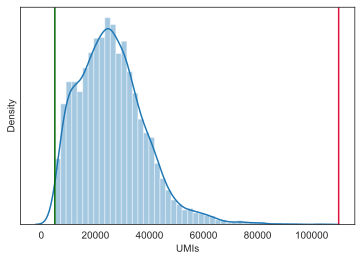

In [6]:
### The first round (high/low UMIs)
properly_sampled_min_cell_total = 5000
properly_sampled_max_cell_total = 110000

total_umis_of_cells = mc.ut.get_o_numpy(raw, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 0 (0.00%) cells with more than 25.00% excluded gene UMIs


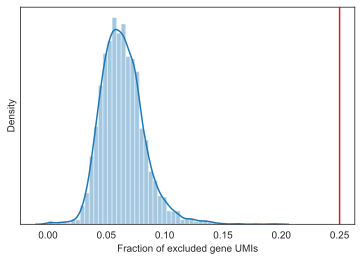

In [7]:
## The second round (content of non-clean genes, e.g., mito-genes)
properly_sampled_max_excluded_genes_fraction = 0.25


excluded_genes_data = mc.tl.filter_data(raw, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [8]:
mc.pl.analyze_clean_cells(
    raw,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction
)
mc.pl.pick_clean_cells(raw)

set cell_lines.obs[properly_sampled_cell]: 3822 true (100%) out of 3822 bools
set cell_lines.obs[clean_cell]: 3822 true (100%) out of 3822 bools


In [9]:
# Extract clean dataset (with fillered cells and genes)
clean = mc.pl.extract_clean_data(raw)

set cell_lines.clean.obs[full_cell_index]: 3822 int64s
set cell_lines.clean.var[full_gene_index]: 11763 int64s


## Computing metacells 

Metacell-2 uses its own feature selection approach (i.e., selection of genes used to build metacells). Additionally, we can explicitely specify which features to use by providing two arguments: 
`feature_gene_names` - genes that have to be used 
`forbidden_gene_names` - genes to exclude.

To be consistent with the pipeline of the [main tutorial](), we will used the same set of genes, used for the metacell construction with the SuperCell approach. To explore how Metacell-2 constructs metacells by default, comment usage of those two parameters. 

In [10]:
feature_gene_names   = clean.var.index[clean.var['use_for_SC_construction'] == True].to_list() # keep genes used in the main tutorial
forbidden_gene_names = [x for x in clean.var_names if x not in feature_gene_names] # exclud all the other

In contrast to the SuperCell and SEACells, Metacell-2 does not allow to explicitely obtain metacell data at a user-defined graining level. Instead, to vary graining level, we have to vary a `target_metacell_size` parameter, that is `160000` by default. Here we provide a chunk to calibrate this value to get a desired graining level. Please, increase  or decrease `scale` if the obtained  grainign level `gamma_obtained` is lower or larger than the requested one (`gamma`).

In [11]:
# Estimate target_metacell_size(gamma):
print(f'The requested graining level is {gamma}, lets estimate the target_metacell_size that should result in such graining level.')

scale = 1 # incres or decrease if the obtained graining level (`gamma_obtained`) is significantly > or < then the requested one `gamma`

N_c = clean.shape[0]

# estimated mean UMI content in dowsampled data
est_downsample_UMI = np.quantile(np.array(total_umis_of_cells), 0.05)

target_metacell_size = int(est_downsample_UMI*gamma) * scale
target_metacell_size

The requested graining level is 20, lets estimate the target_metacell_size that should result in such graining level.


172066

In [12]:
mc.pl.divide_and_conquer_pipeline(
    clean,
    feature_gene_names   = feature_gene_names, # comment this line to allow Metacell2 selecting features
    forbidden_gene_names = forbidden_gene_names, # comment this line to allow Metacell2 selecting features
    target_metacell_size = target_metacell_size,
    random_seed = 123456)

## make anndata of metacells
metacells = mc.pl.collect_metacells(clean, name='cell_lines.metacells')

set cell_lines.clean.var[rare_gene]: 0 true (0%) out of 11763 bools
set cell_lines.clean.var[rare_gene_module]: 11763 int32 elements with all outliers (100%)
set cell_lines.clean.obs[cells_rare_gene_module]: 3822 int32 elements with all outliers (100%)
set cell_lines.clean.obs[rare_cell]: 0 true (0%) out of 3822 bools
set cell_lines.clean.layers[downsampled]: csr_matrix 3822 X 11763 float32s (9334520 > 0)
set cell_lines.clean.uns[downsample_samples]: 7901
set cell_lines.clean.var[forced_gene]: 997 true (8.476%) out of 11763 bools
set cell_lines.clean.var[high_top3_gene]: 3474 true (29.53%) out of 11763 bools
set cell_lines.clean.var[high_total_gene]: 11236 true (95.52%) out of 11763 bools
set cell_lines.clean.var[high_relative_variance_gene]: 2623 true (22.3%) out of 11763 bools
set cell_lines.clean.var[forbidden_gene]: 10766 true (91.52%) out of 11763 bools
set cell_lines.clean.var[feature_gene]: 738 true (6.274%) out of 11763 bools
set cell_lines.clean.obsp[obs_similarity]: ndarray 3

In [13]:
gamma_obtained = clean.shape[0]/metacells.shape[0]

gamma_obtained

23.02409638554217

Check whether the obtained graining level is acceptable or whether a correction of the parameter `scale` is necessary.

In [14]:
gamma_dev = (gamma_obtained - gamma)/gamma
if abs(gamma_dev) < 0.3: 
    gamma_dev = 0

if gamma_dev < 0:
    print("Increase `target_metacell_size` parameter by increasing `scale` and re-run metacell divide_and_conquer_pipeline() to get larger graining level")
elif gamma_dev > 0:
    print("Deacrease `target_metacell_size` parameter by decreasing `scale` and re-run metacell divide_and_conquer_pipeline() to get smaller graining level")
elif gamma_dev == 0:
    print("The obtained graining level is acceptable, no need to re-run the metacell divide_and_conquer_pipeline() with a new `target_metacell_size` ")

The obtained graining level is acceptable, no need to re-run the metacell divide_and_conquer_pipeline() with a new `target_metacell_size` 


In [15]:
gamma_dev

0

## Visualize metacells (optional)

set cell_lines.metacells.var[top_feature_gene]: 738 true (6.274%) out of 11763 bools
set cell_lines.metacells.obsp[obs_balanced_ranks]: 2120 nonzero (7.693%) out of 27556 elements
set cell_lines.metacells.obsp[obs_pruned_ranks]: 664 nonzero (2.41%) out of 27556 elements
set cell_lines.metacells.obsp[obs_outgoing_weights]: 664 nonzero (2.41%) out of 27556 elements
set cell_lines.metacells.obsp[umap_distances]: csr_matrix 166 X 166 float32s (27390 > 0)
/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set cell_lines.metacells.obs[umap_x]: 166 float32s
set cell_lines.metacells.obs[umap_y]: 166 float32s


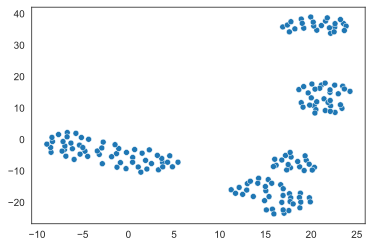

In [16]:
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=123456)
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)

In [17]:
# make a membership (as in SCimplify() from SuperCell) vector
clean.obs['membership'] = [i+1 if i >= 0 else np.nan for i in clean.obs.metacell] 

## Save single-cell metadata (i.e., `raw.obs` dataframe) in the metacell adata object
metacells.uns = clean.uns.copy()
metacells.uns['sc.obs'] = clean.obs.copy()

# save the requested gamma
metacells.uns['gamma'] = gamma

In [18]:
metacells.uns['sc.obs'][['metacell', 'membership']]

,metacell,membership
Lib90_00000,149,150.0
Lib90_00002,151,152.0
Lib90_00003,58,59.0
Lib90_00004,4,5.0
Lib90_00005,-1,NaN
...,...,...
Lib90_04026,69,70.0
Lib90_04028,47,48.0
Lib90_04029,-1,NaN
Lib90_04048,47,48.0


In [19]:
metacells.var.feature_gene.value_counts()

0    11025
1      738
Name: feature_gene, dtype: int64

## Saving data for the further downstream analysis

In [20]:
metacells.write(os.path.join(data_folder, 'output', f'metacell2_gamma_{gamma}.h5ad'))
#clean.obs.to_csv(os.path.join(data_folder, 'output', f'metacell2_gamma_{gamma}.csv'))



In [6]:
adata = sc.read_h5ad(os.path.join(data_folder, 'output', f'metacell2_gamma_{gamma}.h5ad'))